In [43]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, silhouette_score
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv("../complete_data.csv")

# 划分时间序列数据集
train_df = df[df['Year'] < 2024]  # 训练集：2024年前数据
test_df = df[df['Year'] == 2024]  # 测试集：预测2024年

In [45]:
def create_country_features(data):
    """创建基于历史数据的国家特征"""
    features = data.groupby('NOC').agg({
        'Total': ['sum', 'mean', 'std', 'count'],
        'Participants': 'mean',
        'is_host': 'sum'
    })
    features.columns = [
        'Total_sum', 'Total_mean', 'Total_std', 'Total_count',
        'Participants_mean', 'is_host_sum'
    ]
    return features.reset_index()

# 仅在训练集上计算历史特征
country_features = create_country_features(train_df)

# 填充可能的缺失值（如首次参赛国家）
numeric_cols = ['Total_sum', 'Total_mean', 'Total_std', 'Participants_mean', 'is_host_sum']
country_features[numeric_cols] = country_features[numeric_cols].fillna(0)

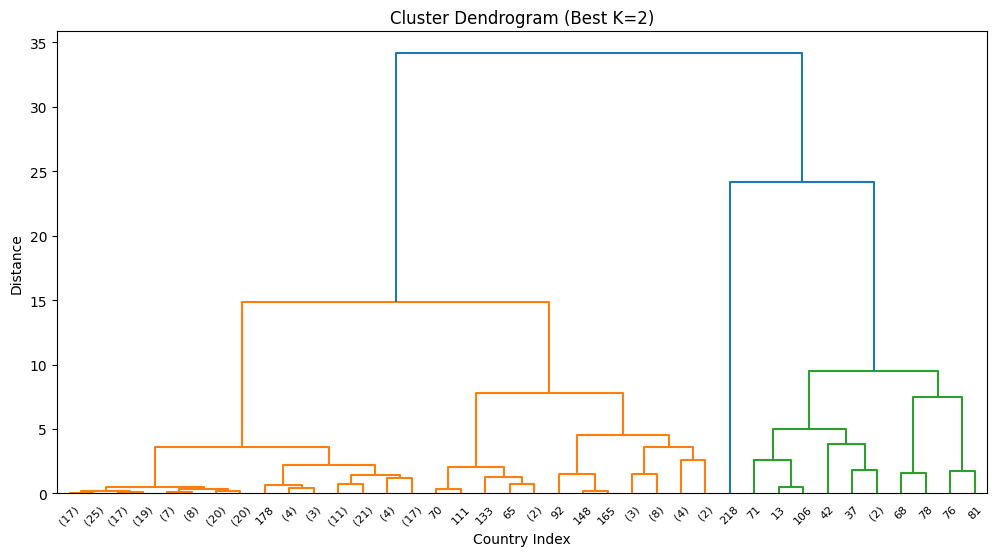

In [46]:
# 标准化特征
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(country_features[numeric_cols])

# 层次聚类
Z = linkage(X_cluster, method='ward')

# 自动选择最佳簇数（2-5个簇范围内）
silhouette_scores = []
for k in range(2, 6):
    labels = fcluster(Z, k, criterion='maxclust')
    silhouette_scores.append(silhouette_score(X_cluster, labels))

best_k = np.argmax(silhouette_scores) + 2  # 转换为实际簇数
clusters = fcluster(Z, best_k, criterion='maxclust')
country_features['cluster'] = clusters

# 可视化聚类结果
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title(f'Cluster Dendrogram (Best K={best_k})')
plt.xlabel('Country Index')
plt.ylabel('Distance')
plt.show()

In [47]:
train_df = train_df.merge(
    country_features[['NOC', 'cluster']],
    on='NOC',
    how='left'
)

,NOC,Year,Bronze,Gold,Silver,Participants,Events,is_host,Total,cluster
0,AFG,1896,0,0,0,0,0,0,0,1
1,AFG,1900,0,0,0,0,0,0,0,1
2,AFG,1904,0,0,0,0,0,0,0,1
3,AFG,1908,0,0,0,0,0,0,0,1
4,AFG,1912,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7419,ZIM,2004,1,1,1,14,4,0,3,1
7420,ZIM,2008,1,1,1,16,6,0,3,1
7421,ZIM,2012,0,1,3,9,4,0,4,1
7422,ZIM,2016,0,0,0,31,7,0,0,1


In [48]:
test_country_features = test_df[['NOC']].drop_duplicates().merge(
    country_features,
    on='NOC',
    how='left'
)

# 处理新国家：使用训练集特征中位数填充
train_medians = country_features[numeric_cols].median()
test_country_features[numeric_cols] = test_country_features[numeric_cols].fillna(train_medians)

# 分配聚类
X_test_cluster = scaler_cluster.transform(test_country_features[numeric_cols])
distances = cdist(X_test_cluster, scaler_cluster.transform(country_features[numeric_cols]))
test_clusters = country_features['cluster'].iloc[np.argmin(distances, axis=1)].values
test_country_features['cluster'] = test_clusters

# 合并到测试集
test_df = test_df.merge(
    test_country_features[['NOC', 'cluster']],
    on='NOC',
    how='left'
)

In [49]:
models = {}
scalers = {}

for cluster_id in country_features['cluster'].unique():
    cluster_data = train_df[train_df['cluster'] == cluster_id]

    if len(cluster_data) == 0:
        continue

    X = cluster_data[['Year', 'Participants', 'Events', 'is_host']]
    y = cluster_data['Total']

    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    scalers[cluster_id] = scaler

    # 动态模型选择
    if len(cluster_data) < 100:
        model = Lasso(alpha=0.01, max_iter=5000)
    else:
        model = RandomForestRegressor(n_estimators=100,
                                      max_depth=5,
                                      random_state=42)
    model.fit(X_scaled, y)
    models[cluster_id] = model

In [50]:
def safe_predict(row):
    cluster_id = row['cluster']
    if pd.isna(cluster_id) or cluster_id not in models:
        # 使用全局中位数作为保底预测
        return train_df['Total'].median()

    model = models[cluster_id]
    scaler = scalers[cluster_id]

    try:
        X = scaler.transform([[row['Year'], row['Participants'],
                               row['Events'], row['is_host']]])
        return max(0, model.predict(X)[0])  # 确保非负
    except:
        return train_df['Total'].median()


test_df['predicted_total'] = test_df.apply(safe_predict, axis=1)

# 输出结果
print("\n2024年预测结果：")
print(test_df[['NOC', 'Year', 'predicted_total']].sort_values('predicted_total', ascending=False))

# 保存结果
test_df.to_csv('predicted_results.csv', index=False)


C:\anaconda\envs\CSCI3230\ICM2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\anaconda\envs\CSCI3230\ICM2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\anaconda\envs\CSCI3230\ICM2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\anaconda\envs\CSCI3230\ICM2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\anaconda\envs\CSCI3230\ICM2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warni


2024年预测结果：
     NOC  Year  predicted_total
81   GER  2024       118.979032
13   AUS  2024       118.979032
218  USA  2024       100.237544
71   FRA  2024        77.164622
42   CHN  2024        56.151297
..   ...   ...              ...
178  SCG  2024         0.017217
26   BLR  2024         0.017217
27   BOH  2024         0.017217
200  TCH  2024         0.017217
52   CRT  2024         0.017217

[232 rows x 3 columns]


PermissionError: [Errno 13] Permission denied: 'predicted_results.csv'

In [54]:
# --------------------------
# 输出聚类结果
# --------------------------
print("\n聚类结果：")
country_features[['NOC', 'cluster']].sort_values('cluster')



聚类结果：


,NOC,cluster
0,AFG,1
146,NBO,1
147,NCA,1
148,NED,1
149,NEP,1
...,...,...
78,GDR,2
71,FRA,2
81,GER,2
196,SWE,2
